<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/RNN_with_the_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN with the Signals

Considering the EEG signals with 63 channels as multivarian time series, It may be usefull to use the RNN models to classify the signals



* Since every subject has 25 trials, so it is resonal(and also better) to compute the mean of every 21 signal and then use them as classification signals. in this case we will have $\dfrac{25!}{22! 3!} = 2300 $  new data that the hase higher signal to noise ration.($\sigma*^2 = \sigma^2/22)$. This is by **FAR** more than perfect. becaues in this case for every class we will have $2300*15 = 34500 $ multivariante time series (each has 63 channels with 7200 data points). Lots of data!

* Using CNN with RNN, with little kernel size compered to the size of the artifact may neglect the eye blink artifacts

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters
import random

In [2]:
subj_15 = datafetch.fetch_subject(15)
subj_15.keys()

dict_keys(['test_data', 'train_data_class1', 'train_data_class2', 'train_data_class3', 'train_data_class4'])

In [0]:
a = [0, 15, 2, 4, 16, 23, 6, 14, 20, 24, 8, 3, 1, 21, 7, 9, 13, 5, 18, 10, 19, 4]

In [4]:
subj_15['train_data_class1'][a].shape

(22, 7200, 63)

In [5]:
np.mean(subj_15['train_data_class1'], axis=0).shape

(7200, 63)

In [0]:
from plotters import EEG_plotter

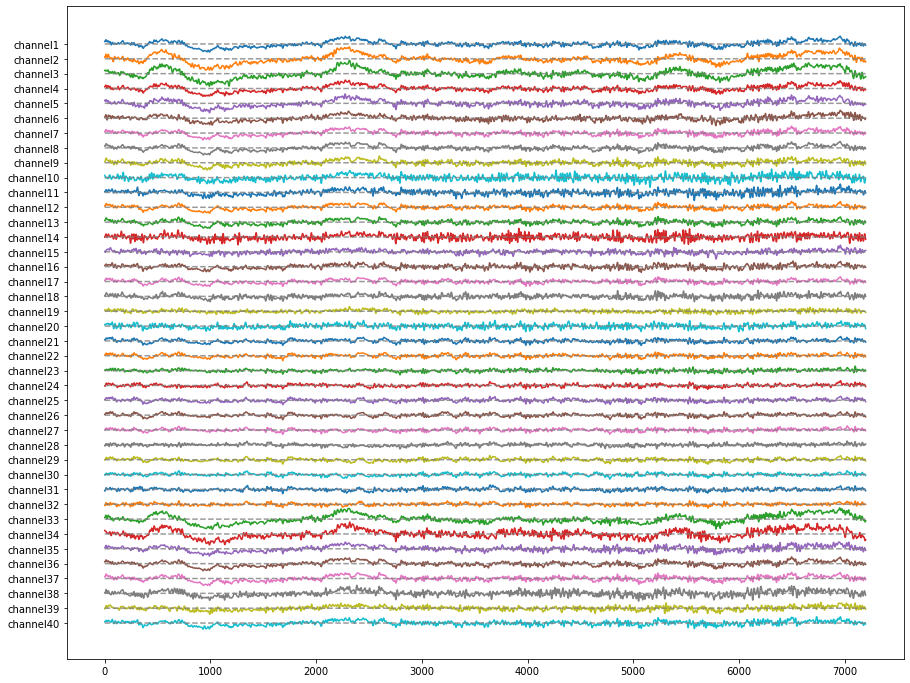

In [7]:
EEG_plotter(40,np.mean([subj_15['train_data_class1'][i] for i in range(21)], axis = 0))

## Data Preparation

In [0]:
global subj_list 
global selector
global indexes
subj_list = [0,0,0,0,0,0]

In [0]:
indexes = [i for i in range(25)]

In [0]:
def selector_desing(sector, classes=[1,4], trail=[0,24]):
  selector = []
  for i in range((sector-1)*5+1, sector*5+1):
    for j in range(classes[0],classes[1]+1):
      for k in range(0,trail[1]+1):
        selector.append((i,j,k))
  selector = np.array(selector)
  np.random.shuffle(selector)

  return selector

In [40]:
selector_desing(1)

array([[ 4,  3, 23],
       [ 2,  2, 19],
       [ 2,  1, 17],
       ...,
       [ 5,  2, 13],
       [ 5,  2, 23],
       [ 5,  1, 20]])

In [0]:
def update_subjlist(sector):

  if sector ==1:
    subj_1 = datafetch.fetch_subject(1)
    subj_2 = datafetch.fetch_subject(2)
    subj_3 = datafetch.fetch_subject(3)
    subj_4 = datafetch.fetch_subject(4)
    subj_5 = datafetch.fetch_subject(5)
    return np.array([subj_1, subj_2, subj_3, subj_4, subj_5, 1])


  if sector ==2:
    subj_6 = datafetch.fetch_subject(6)
    subj_7 = datafetch.fetch_subject(7)
    subj_8 = datafetch.fetch_subject(8)
    subj_9 = datafetch.fetch_subject(9)
    subj_10 = datafetch.fetch_subject(10)

    return np.array([0,0,0,0,0] + [subj_6, subj_7, subj_8, subj_9, subj_10, 2])


  if sector ==3:
    subj_11 = datafetch.fetch_subject(11)
    subj_12 = datafetch.fetch_subject(12)
    subj_13 = datafetch.fetch_subject(13)
    subj_14 = datafetch.fetch_subject(14)
    subj_15 = datafetch.fetch_subject(15)

    return np.array([0,0,0,0,0] + [0,0,0,0,0] + [subj_11, subj_12, subj_13, subj_14, subj_15, 3])


In [0]:
def select_data(select):
  '''
  it selects the data according the the selector.
  for exmaple if the seclevto os equal to (3,4,1) the
  data of subject number 1, which belongs to the class number 4, and its 1 trail 
  will be selected. which is a 7200 data point with 63 channels
  '''
  global subj_list
  global indexes
  this_trail = select[2]
  samples = random.sample(indexes, 21)
  samples += [this_trail]
  #print(samples)
  return np.mean(subj_list[select[0]-1]['train_data_class{}'.format(select[1])][samples], axis=0)

In [0]:
def meaned_item(item):

  global selector
  global subj_list
  
  '''
  function will get item (the index of the patient) and will return the hilbert 
  images that each channel of eeg will be different channels of the retured image

  This fuction will also return the label. for example the label 1 indicates that
  the patient belongs to the class number 1
  '''

  #bins = bin_creator(np.array([530,-370]*3600), 120)

  
  
  mat = select_data(selector[int(item%len(selector))])
  mats = mat
  label = selector[int(item%len(selector))][1]

  return mats, label

In [0]:
def load_Meaned_batch(n=[0, 2],sector=1):
  '''
  Note that since we have meaned over 22 samples, so for each subject and for each class there are 2300 timeseries.

  So each sector will contain 4*5*2300 = 46000 (previously it was 4*5*25 = 500).
  So you can vary the n from 0 to 46000


  '''

  global subj_list
  global selector

  labels = []

  Data = []
  if sector != subj_list[-1]:
    subj_list = update_subjlist(sector)
    selector = selector_desing(sector)

  data, label = meaned_item(n[0])
  Data.append(data)
  labels.append(label)
  for i in range(n[0]+1, n[1]):
    data, label  = meaned_item(i)
    labels.append(label)
    Data.append(data)

  '''
  Label = []
  pre_data = []

  for i in Data:
    pre_data+=i

  #for j in labels:
    #Label += j

  #labels = Label
  Data = predata
   '''


  return np.array(Data), np.array(labels)

In [16]:
data, label = load_Meaned_batch([1200,1202], sector=1)
label

array([4, 3])

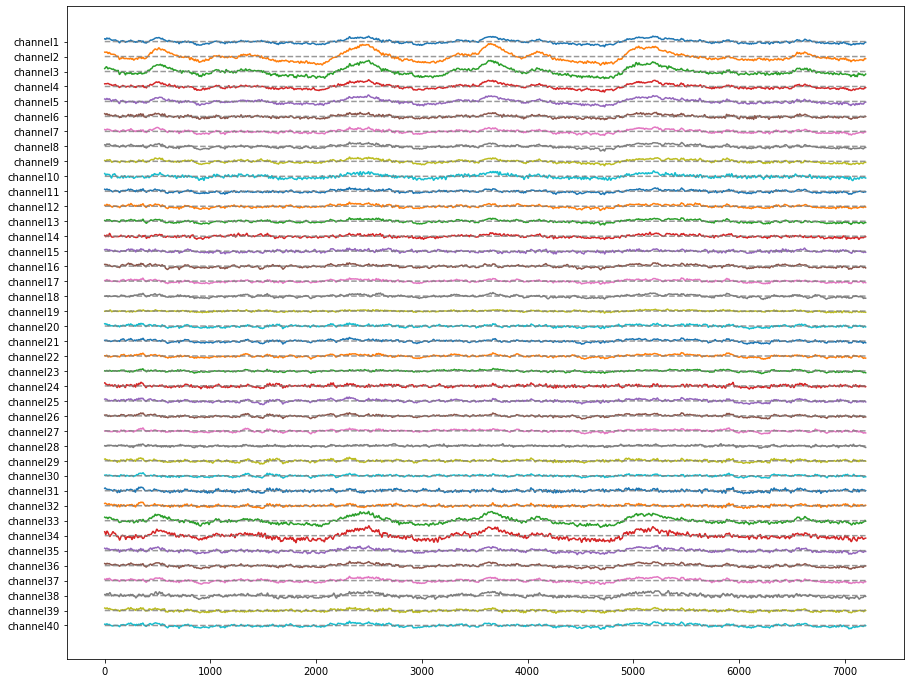

In [17]:
EEG_plotter(40, data[0])

# The RNN model for classification

In [0]:
from tensorflow import keras

In [0]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D( 20, 80, strides=40, input_shape=[None, 63], activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(50, return_sequences=True))
model.add(keras.layers.LSTM(30))
model.add(keras.layers.Dense(30, activation = 'relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(4, activation ='softmax'))

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 20)          100820    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          14200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics= ['accuracy'])

In [49]:
Sectors = [1,2,3]
intervals = [[600*i,600*(i+1)] for i in range(22)]
for epoch in range(1):
  for sec in Sectors:
    for interval in intervals:
      data, label = load_Meaned_batch(interval, sec)
      model.fit(data, label-1, epochs=2, validation_split=0.1)
      print('############################')
      print('############################')
      print('sector:{}    and    interval:{}    and    epoch:{}'.format(sec, interval, epoch))
      print('############################')
      print('############################')

Epoch 1/2
17/17 [==============================] - 1s 75ms/step - loss: 1.3431 - accuracy: 0.3333 - val_loss: 1.2750 - val_accuracy: 0.4000
Epoch 2/2
17/17 [==============================] - 1s 36ms/step - loss: 1.2571 - accuracy: 0.3944 - val_loss: 1.2009 - val_accuracy: 0.4500
############################
############################
sector:1    and    interval:[0, 600]    and    epoch:0
############################
############################
Epoch 1/2
17/17 [==============================] - 1s 40ms/step - loss: 1.1552 - accuracy: 0.4630 - val_loss: 1.0495 - val_accuracy: 0.5000
Epoch 2/2
17/17 [==============================] - 1s 37ms/step - loss: 1.0257 - accuracy: 0.5148 - val_loss: 0.9755 - val_accuracy: 0.4667
############################
############################
sector:1    and    interval:[600, 1200]    and    epoch:0
############################
############################
Epoch 1/2
17/17 [==============================] - 1s 40ms/step - loss: 0.8777 - accuracy: 0.56

ResourceExhaustedError: ignored

In [0]:
model.save('CNN_RNN.h5')

In [0]:
del data, label

In [0]:
x_test, y_test = load_Meaned_batch([15000,16000], sector=2)

In [21]:
model.evaluate(x_test, y_test-1)

32/32 [==============================] - 1s 28ms/step - loss: 1.9140 - accuracy: 0.6080


[1.9139653444290161, 0.6079999804496765]

In [0]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
confusion_matrix(y_test, pred+1)

array([[140,  87,   6,  17],
       [ 65, 161,  20,   4],
       [ 20,   4, 194,  32],
       [  8,  54,  75, 113]])

In [29]:
print(classification_report(y_test, pred+1))

              precision    recall  f1-score   support

           1       0.60      0.56      0.58       250
           2       0.53      0.64      0.58       250
           3       0.66      0.78      0.71       250
           4       0.68      0.45      0.54       250

    accuracy                           0.61      1000
   macro avg       0.62      0.61      0.60      1000
weighted avg       0.62      0.61      0.60      1000



#Trash

In [0]:
import random

In [0]:
random.sample([i for i in range(25)], 10)

In [0]:
np.random.sample([i for i in range(25)], 4)